## Importar los Datos de Stackoverflow

### Descarga de los CSV

Descargamos los CSV:

!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001 -O - > es.stackoverflow.csv.7z
!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.002 -O - >> es.stackoverflow.csv.7z

Descomprimimos y borramos el archivo comprimido

!7zr x -aoa es.stackoverflow.csv.7z
!rm es.stackoverflow.csv.7z

### Importar la Base de Datos a PyArrow

In [3]:
# Probamos la importación automática de Arrow
# Utilizamos datasets para que sea más eficiente en memoria
from pyarrow import csv
import pyarrow.dataset as ds

posts = ds.dataset("Posts.csv", format="csv")
users = ds.dataset("Users.csv", format="csv")
tags = ds.dataset("Tags.csv", format="csv")
votes = ds.dataset("Votes.csv", format="csv")
comments = ds.dataset("Comments.csv", format="csv")

print(f""" - Schemas:
## Posts: {posts.count_rows()} filas
{posts.schema}
\n
## Users: {users.count_rows()} filas
{users.schema}
\n
## Tags: {tags.count_rows()} filas
{tags.schema}
\n
## Votes: {votes.count_rows()} filas
{votes.schema}
\n
## Comments: {comments.count_rows()} filas
{comments.schema}""")

 - Schemas:
## Posts: 410346 filas
Id: int64
AcceptedAnswerId: int64
AnswerCount: int64
Body: string
ClosedDate: timestamp[ns]
CommentCount: int64
CommunityOwnedDate: timestamp[ns]
ContentLicense: string
CreationDate: timestamp[ns]
FavoriteCount: int64
LastActivityDate: timestamp[ns]
LastEditDate: timestamp[ns]
LastEditorDisplayName: string
LastEditorUserId: int64
OwnerDisplayName: string
OwnerUserId: int64
ParentId: int64
PostTypeId: int64
Score: int64
Tags: string
Title: string
ViewCount: int64


## Users: 319535 filas
Id: int64
AboutMe: string
AccountId: int64
CreationDate: timestamp[ns]
DisplayName: string
DownVotes: int64
LastAccessDate: timestamp[ns]
Location: string
Reputation: int64
UpVotes: int64
Views: int64
WebsiteUrl: string


## Tags: 3048 filas
Id: int64
Count: int64
ExcerptPostId: int64
TagName: string
WikiPostId: int64


## Votes: 787607 filas
Id: int64
BountyAmount: int64
CreationDate: timestamp[ns]
PostId: int64
UserId: int64
VoteTypeId: int64


## Comments: 689730 fi

## Ejercicios
### RQ1: Distribution of Questioners
We plot the histogram of questioners in Figure 3. The graph shows the number of developers that ask a given number of questions, and its y-axis is in log-scale. From the graph, we notice that most developers (33,907 out of 44,087 developers) only ask one question. Only about 23.1% of the developers ask two or more questions. The number of developers that ask questions reduces exponentially as we consider a higher number of posted questions. Only 1.6% of the developers ask more than 5 questions. 

The result shows that there are few “regular” questioners on StackOverflow. This is possibly because many questions have already been asked before and users could find answers to them by just looking into the various pages on StackOverflow or other question and answer sites via search engines

In [98]:
import pyarrow.compute as pc
import pandas as pd

question_count = (
    posts.to_table(filter=pc.field("PostTypeId") == 1)
    .group_by("OwnerUserId")
    .aggregate([("Id", "count")])
    # Drop de OwnerUserId nulo para que Pandas tome la columna como Int
    .drop_null()
    .rename_columns(["OwnerUserId", "QuestionCount"])
)

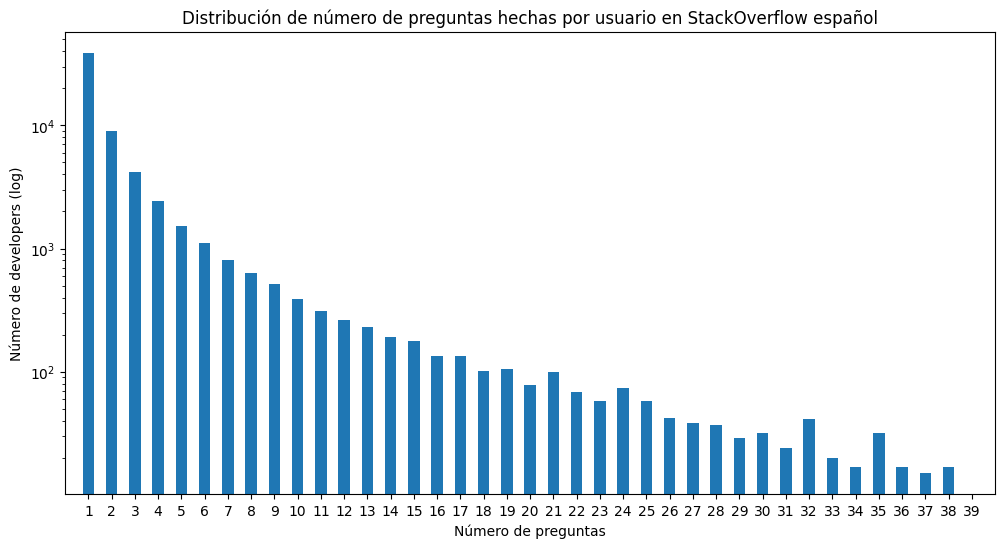

In [99]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize= (12,6))
plt.hist(question_count.to_pandas()['QuestionCount'], 
        bins=np.arange(1,40)-0.5, # type: ignore
        range = (1,40), log=True, rwidth = 0.5) 
plt.xlim(0,40)
plt.xticks(range(1,40))
plt.title('Distribución de número de preguntas hechas por usuario en StackOverflow español')
plt.xlabel('Número de preguntas')
plt.ylabel('Número de developers (log)')
plt.show()

In [150]:
# Numero total de usuarios activos
active_users = pc.count_distinct(
    posts.to_table(filter=pc.field("PostTypeId").isin([1, 2]))
    ["OwnerUserId"].drop_null()
).as_py()

active_with_questions = question_count.num_rows

users_1q = question_count.filter(pc.field("QuestionCount") == 1).num_rows
users_more1a = active_with_questions - users_1q
users_more5a = question_count.filter(pc.field("QuestionCount") > 5).num_rows

prop_pregunta = active_with_questions / active_users
prop_1 = users_1q / active_with_questions
prop_more1a = users_more1a / active_with_questions
prop_more5a = users_more5a / active_with_questions

print(f"Total de usuarios con preguntas: {active_with_questions} ({prop_pregunta:.2%} de los usuarios activos)")
print(f"Usuarios que hicieron solo 1 pregunta: {users_1q} ({prop_1:.2%} de los que preguntan)")
print(f"Usuarios que hicieron 2 o más preguntas: {users_more1a} ({prop_more1a:.2%} de los que preguntan)")
print(f"Usuarios que hicieron más de 5 preguntas: {users_more5a} ({prop_more5a:.2%} de los que preguntan)")

Total de usuarios con preguntas: 61993 (78.79% de los usuarios activos)
Usuarios que hicieron solo 1 pregunta: 38481 (62.07% de los que preguntan)
Usuarios que hicieron 2 o más preguntas: 23512 (37.93% de los que preguntan)
Usuarios que hicieron más de 5 preguntas: 6393 (10.31% de los que preguntan)


### RQ2: Distribution of Answerers
We plot the histogram of answerers in Figure 3. The graph shows the number of developers that answer a given num- ber of questions and its y-axis is also in log-scale. From the graph, we notice that most developers (28,578 out of 44,087 developers) only answer one question. About one thousand developers (2.3%) do not answer any questions. Only about 35.2% of the developers answer two or more questions. The number of developers that answer questions reduces expo- nentially as we consider a higher number of answers. On- ly 7.8% of the developers answer more than 5 questions. The highest number of questions a developer answers in our dataset is 178. There is only one developer that answers this many questions.

Compared with the distribution of questioners, the distribution of answers is different. The number of developers that answer a substantial number of questions (> 5) is more than the number of developers that ask a substantial number of questions (> 5)—3,424 (7.8%) versus 701 (1.6%). This may imply that many developers on StackOverflow are interested

In [126]:
import pyarrow as pa
answer_count = (
    posts.to_table(filter=pc.field("PostTypeId") == 2)
    .group_by("OwnerUserId")
    .aggregate([("Id", "count")])
    .drop_null()
    .rename_columns(["OwnerUserId", "AnswerCount"])
)

users_zero_answers = active_users - answer_count.num_rows

distribution = (
    answer_count.group_by("AnswerCount")
    .aggregate([("OwnerUserId", "count")])
    .rename_columns(["AnswerCount", "UserCount"])
)

zero_answers = pa.Table.from_pydict({"AnswerCount":[0], "UserCount":[users_zero_answers]})
distribution = pa.concat_tables([distribution, zero_answers])


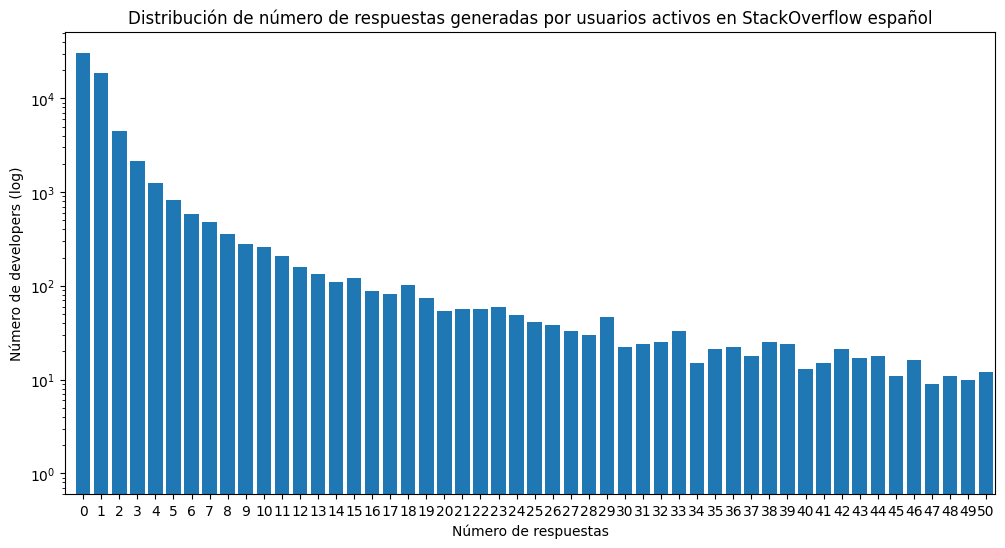

In [121]:
plt.figure(figsize=(12, 6))
plt.bar(
    distribution.to_pandas()["AnswerCount"],
    distribution.to_pandas()["UserCount"],
    log=True,
)
plt.xlim((-1, 50.5))
plt.xticks(range(51))
plt.title(
    "Distribución de número de respuestas generadas por usuarios activos en StackOverflow español"
)
plt.xlabel("Número de respuestas")
plt.ylabel("Número de developers (log)")
plt.show()

In [153]:
# Total de usuarios con respuestas
active_with_answers = answer_count.num_rows

users_1q = question_count.filter(pc.field("QuestionCount") == 1).num_rows
users_more1a = active_users - users_1q
users_more5a = question_count.filter(pc.field("QuestionCount") > 5).num_rows

# Usuarios que dieron solo 1 respuesta
users_1a = answer_count.filter(pc.field("AnswerCount") == 1).num_rows
users_more1a = active_with_answers - users_1a
users_more5a = answer_count.filter(pc.field("AnswerCount") > 5).num_rows
max_answers = pc.max(answer_count["AnswerCount"]).as_py()

prop_respuesta = (active_with_answers / active_users) 
prop_1 = (users_1a / active_with_answers) 
prop_more1a = (users_more1a / active_with_answers) 
prop_more5a = (users_more5a / active_with_answers) 

print(f"Total de usuarios con preguntas: {active_with_answers} ({prop_respuesta:.2%} de los usuarios activos)")
print(f"Usuarios que hicieron solo 1 pregunta: {users_1q} ({prop_1:.2%} de los que responden)")
print(f"Usuarios que hicieron 2 o más preguntas: {users_more1a} ({prop_more1a:.2%} de los que responden)")
print(f"Usuarios que hicieron más de 5 preguntas: {users_more5a} ({prop_more5a:.2%} de los que responden)")
print(f"Número máximo de respuestas de un usuario: {max_answers}")

Total de usuarios con preguntas: 31650 (40.23% de los usuarios activos)
Usuarios que hicieron solo 1 pregunta: 38481 (58.43% de los que responden)
Usuarios que hicieron 2 o más preguntas: 13156 (41.57% de los que responden)
Usuarios que hicieron más de 5 preguntas: 4438 (14.02% de los que responden)
Número máximo de respuestas de un usuario: 5728


### RQ3: Segregation of StackOverflow Community
To answer this research question, we investigate the proportion of posts that various developers make that are answers to some questions. We show this in Figure 5. We notice that a majority of developers only ask questions but do not answers them (83.2%, 36,672 developers). Thus, we could divide the StackOverflow community into two groups: people that only ask questions, and those that answer one or more questions. The first group is the majority.

We also note another peak in Figure 5: These are developers (2,956 of 44,087 developers), with 50-59% of posts being answers. These correspond to ideal developers that contribute answers to the community as much as requesting answers from the community.

### RQ4: RQ4: Reciprocity in StackOverflow
To answer the fourth research question, we investigate the help graph. A help graph is a directed graph, where each developer is a node, and the node corresponding to a developer D1 is linked to that of D2 if D1 answers a question posted by D2. We would like to investigate how often two developers D1 and D2 are connected by two edges, one from D1 to D2 and the other from D2 to D1. We find that there are only a few of such developers (23 pairs). We highlight a few in Table 1. The table contains the identifiers of the helpers and helpees that reciprocate. From the result, we hypothesize that developers tend to help anyone no matter if they have helped him or her before and StackOverflow tends to benefit the community as a whole.